In [1]:
from SplitWindows import SplitWindows
from AttentionArea import TemporalAttention , SpatialAttention , DynamicMatrix , AttentionBlock
from torch_geometric.nn import GCNConv
from Config import CONFIG
from Dataset import TimeSDataset
import engine

import numpy as np
import pandas as pd 
import torch
from torch import nn
from torch_geometric.nn import GCNConv
from torch.utils.data import DataLoader

Config = CONFIG()
device = "cuda" if torch.cuda.is_available else "cpu"

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
Config.T , Config.P_2 

(39, 22)

In [3]:
### Write the Main Class

class DynDeepNet(nn.Module):
    def __init__(self ):
        super().__init__()
        # Define Clf token
        self.CLFToken = torch.nn.Parameter(torch.rand(1, Config.T_prim, 1))
        # Define Temporal Attention
        self.TAttention = TemporalAttention (Config.NUM_H1 ,Config.V * Config.P_2 , Config.HIDDEN_DIM)
        # Define Spatial Attention 
        self.SAttention = SpatialAttention()
        # Define Dynamic Matrix
        self.Dm = DynamicMatrix()
        # Define GCN Layer
        self.gcn_layer = GCNConv(in_channels=Config.P_2, out_channels=Config.K_F)
        # Define Final Encoder layers
        self.Transformer = nn.Sequential(*[AttentionBlock(Config.K_E * Config.K_F, Config.HIDDEN_DIM, Config.NUM_H2, Config.DROP_OUT) for _ in range(Config.NUM_LAYER)])
        self.Mlp_head = nn.Sequential(
            nn.LayerNorm(Config.K_E * Config.K_F),
            nn.Linear(Config.K_E * Config.K_F, Config.NUM_CLASS)
        )
        self.Dropout = nn.Dropout(Config.DROP_OUT)
        self.Flatten = nn.Flatten(2,-1)
        self.MeanDynamicMatrix = 0
        
    def forward(self,x):
        ### Input : (B , T_Prim , V)
        B , _ , _ = x.shape
        ## ADD CLF TOKEN
        CLFToken = self.CLFToken.repeat(B, 1 ,1)
        # print(f"CLFToken Gradeient {self.CLFToken} , {self.CLFToken.shape}")
        x = torch.concatenate([CLFToken, x], axis=-1)
        
        ## Convert Signal Serie to the Window Signal
        x = SplitWindows(x)  ## OutPut : (B , T , V ,P)
        ## Temporal Transformer
        x = self.TAttention(x)  ## OutPut : (B , K_E , V , P_2)
        ## Spatial Attention
        x = self.SAttention(x)    ## OutPut : (B , K_E , V , P_2)
        ## Dynamic Matrix
        A = self.Dm(x)           ## OutPut  : (B , K_E , V , V)
        self.MeanDynamicMatrix = A
        ## GCN Layer
        BatchTensor = torch.empty(B, Config.K_E, Config.V, Config.K_F, dtype=x.dtype, device=x.device)
        # Iterate over each graph in the batch
        for i in range(B):
            # Extract the adjacency matrix for the current graph
            adj_i = A[i]  # Shape (T, V, V)
            for t in range(Config.T):
                # Get the edge indices and weights for the current time step
                edge_index = adj_i[t].nonzero(as_tuple=False).T  # Shape (2, E)
                edge_weights = adj_i[t][edge_index[0], edge_index[1]]  # Shape (E,)
                # Select the corresponding node features for the current time step
                x_t = x[i][t]
                # Apply the GCN layer
                x_t = self.gcn_layer(x_t, edge_index, edge_weight=edge_weights)
                # Store the output for the current time step
                # out.append(x_t)
            BatchTensor[i , t ] = x_t
        
        # Stack the output to get the final representation
        x = BatchTensor  ## OUTPUT : (B , K_E , V , K_F) 
        # Transpose
        x = x.transpose(1,2)  ## OUTPUT : (B , V , K_E , K_F)
        # Flatten
        x = self.Flatten(x)  ## OUTPUT  : (B , V , K_E * K_F)
        # Drop Out
        # x = self.Dropout(x)
        # Apply Final Encoder
        x = x.transpose(0,1)
        x = self.Transformer(x)   ## OUTPUT : (V , B , K_E * K_F)
        # Apply Linear Head
        cls = x[0]
        # print(cls)
        return self.Mlp_head(cls)

Model = DynDeepNet()
        

## Define Dataset & DataLoaders

In [4]:
TrainDataset = TimeSDataset("../Data/AAL/Train","Gender",label_path="../Data/Behavioral-HCP.csv")
TestDataset = TimeSDataset("../Data/AAL/Test","Gender",label_path="../Data/Behavioral-HCP.csv")

In [5]:
TrainDataLoader = DataLoader(TrainDataset ,Config.B ,shuffle = False ,num_workers= 8)
TestDataLoader = DataLoader(TestDataset ,Config.B ,shuffle = False ,num_workers= 8)

## Train the model

In [6]:
### 
LR = 0.1
Pivot = 65
Part = 1
Epochs = 40
save_weights = True
###
optimizer = torch.optim.AdamW(Model.parameters() , LR)
loss_fn = torch.nn.CrossEntropyLoss()

  0%|                                                                                                                                                                                                                | 0/40 [00:00<?, ?it/s]

CLFToken Gradeient Parameter containing:
tensor([[[-1.0631],
         [-1.5922],
         [ 0.3606],
         ...,
         [ 0.0743],
         [ 0.3607],
         [ 0.7417]]], device='cuda:0', requires_grad=True)


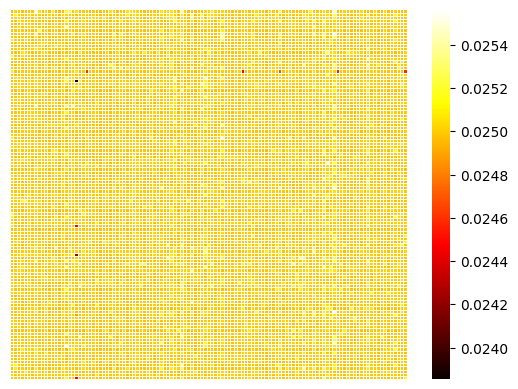

  2%|█████                                                                                                                                                                                                   | 1/40 [00:36<23:55, 36.80s/it]

Epoch: 1 | train_loss: 11.5506 | train_acc: 0.5028 | test_loss: 1.2679 | test_acc: 0.4545
CLFToken Gradeient Parameter containing:
tensor([[[-2.0161],
         [-0.2085],
         [ 1.4488],
         ...,
         [ 0.0623],
         [ 0.3025],
         [ 0.6219]]], device='cuda:0', requires_grad=True)


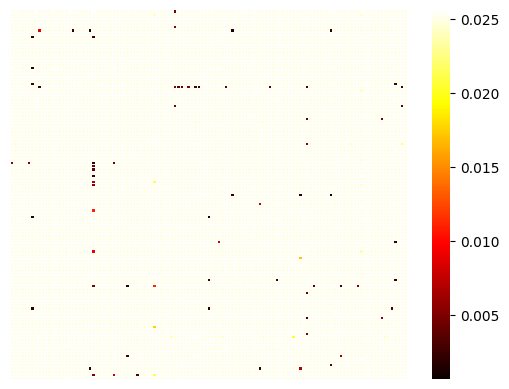

  5%|██████████                                                                                                                                                                                              | 2/40 [01:14<23:39, 37.35s/it]

Epoch: 2 | train_loss: 1.0928 | train_acc: 0.4943 | test_loss: 0.7850 | test_acc: 0.4773
CLFToken Gradeient Parameter containing:
tensor([[[-1.6358],
         [-0.1608],
         [ 1.7570],
         ...,
         [ 0.0523],
         [ 0.2536],
         [ 0.5215]]], device='cuda:0', requires_grad=True)


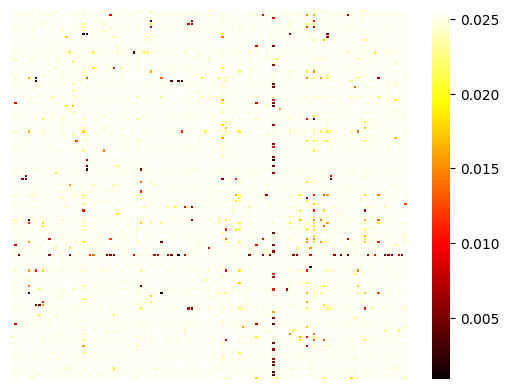

  8%|███████████████                                                                                                                                                                                         | 3/40 [01:52<23:14, 37.69s/it]

Epoch: 3 | train_loss: 2.2618 | train_acc: 0.4545 | test_loss: 1.7118 | test_acc: 0.4091
CLFToken Gradeient Parameter containing:
tensor([[[-1.3729],
         [-0.1355],
         [ 1.4595],
         ...,
         [ 0.0438],
         [ 0.2127],
         [ 0.4373]]], device='cuda:0', requires_grad=True)


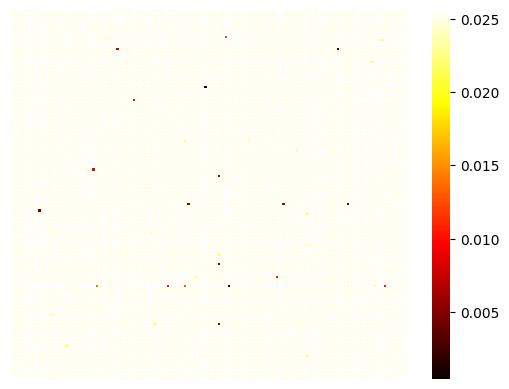

 10%|████████████████████                                                                                                                                                                                    | 4/40 [02:30<22:38, 37.74s/it]

Epoch: 4 | train_loss: 2.9968 | train_acc: 0.4830 | test_loss: 13.3618 | test_acc: 0.4659
CLFToken Gradeient Parameter containing:
tensor([[[-1.7463],
         [-0.6087],
         [-1.5754],
         ...,
         [ 0.0367],
         [ 0.1783],
         [ 0.3667]]], device='cuda:0', requires_grad=True)


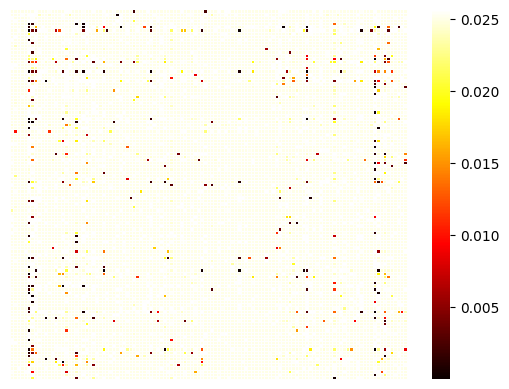

 12%|█████████████████████████                                                                                                                                                                               | 5/40 [03:08<22:05, 37.88s/it]

Epoch: 5 | train_loss: 9.4015 | train_acc: 0.4688 | test_loss: 5.9394 | test_acc: 0.4318
CLFToken Gradeient Parameter containing:
tensor([[[-0.3285],
         [ 0.8007],
         [-1.2285],
         ...,
         [ 0.0308],
         [ 0.1495],
         [ 0.3075]]], device='cuda:0', requires_grad=True)


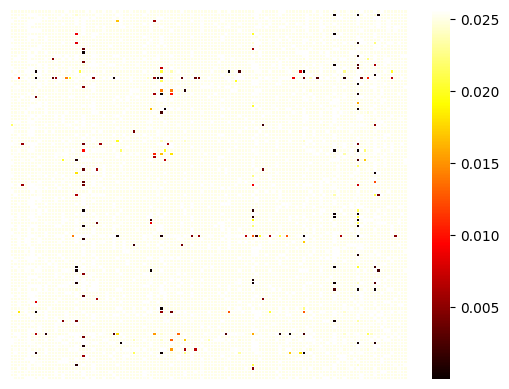

 15%|██████████████████████████████                                                                                                                                                                          | 6/40 [03:46<21:27, 37.87s/it]

Epoch: 6 | train_loss: 20.5785 | train_acc: 0.4688 | test_loss: 32.7868 | test_acc: 0.4659
CLFToken Gradeient Parameter containing:
tensor([[[-1.3814],
         [ 0.1045],
         [ 1.2824],
         ...,
         [ 0.0258],
         [ 0.1254],
         [ 0.2579]]], device='cuda:0', requires_grad=True)


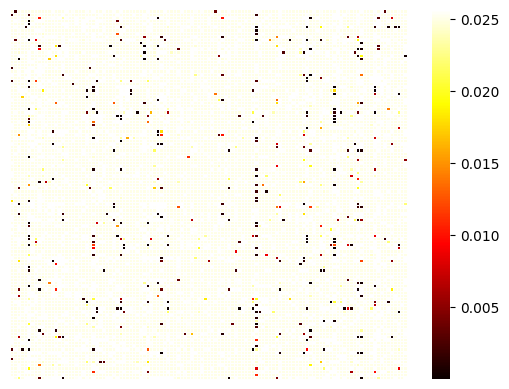

 18%|███████████████████████████████████                                                                                                                                                                     | 7/40 [04:23<20:44, 37.72s/it]

Epoch: 7 | train_loss: 12.0082 | train_acc: 0.5284 | test_loss: 2.0304 | test_acc: 0.4545
CLFToken Gradeient Parameter containing:
tensor([[[-2.2037],
         [-1.5027],
         [-0.8543],
         ...,
         [ 0.0217],
         [ 0.1052],
         [ 0.2162]]], device='cuda:0', requires_grad=True)


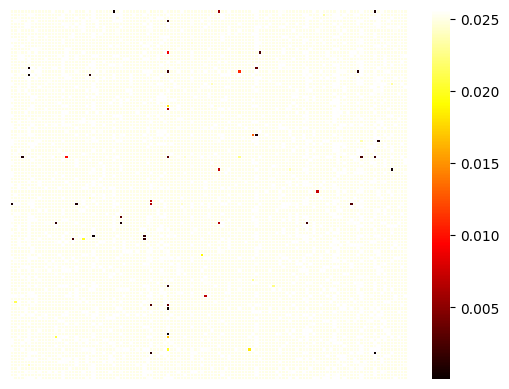

 20%|████████████████████████████████████████                                                                                                                                                                | 8/40 [05:01<20:05, 37.67s/it]

Epoch: 8 | train_loss: 3.7527 | train_acc: 0.4886 | test_loss: 1.8455 | test_acc: 0.5682
CLFToken Gradeient Parameter containing:
tensor([[[-1.5166],
         [ 1.4424],
         [ 1.8388],
         ...,
         [ 0.0182],
         [ 0.0882],
         [ 0.1813]]], device='cuda:0', requires_grad=True)


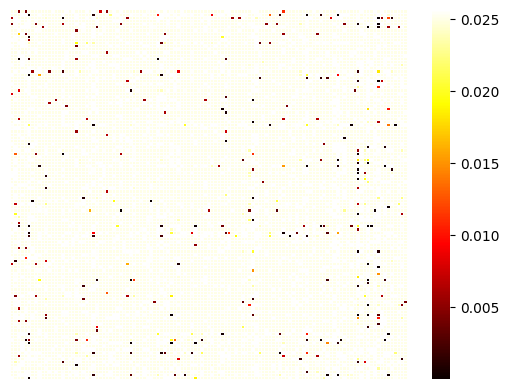

 22%|█████████████████████████████████████████████                                                                                                                                                           | 9/40 [05:38<19:25, 37.58s/it]

Epoch: 9 | train_loss: 1.6174 | train_acc: 0.4801 | test_loss: 0.8462 | test_acc: 0.5455
CLFToken Gradeient Parameter containing:
tensor([[[-1.1183],
         [ 1.1361],
         [ 2.0111],
         ...,
         [ 0.0152],
         [ 0.0739],
         [ 0.1520]]], device='cuda:0', requires_grad=True)


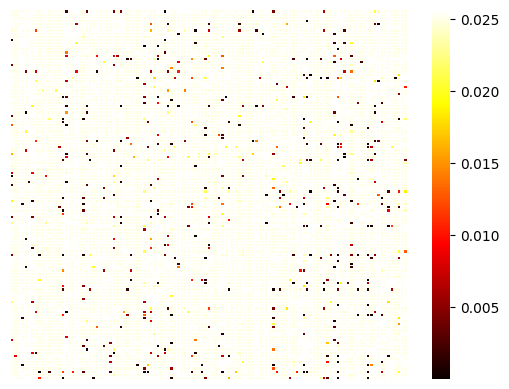

 25%|█████████████████████████████████████████████████▊                                                                                                                                                     | 10/40 [06:18<19:04, 38.13s/it]

Epoch: 10 | train_loss: 0.9433 | train_acc: 0.5398 | test_loss: 0.7333 | test_acc: 0.4545
CLFToken Gradeient Parameter containing:
tensor([[[-0.9459],
         [ 0.8358],
         [ 1.4231],
         ...,
         [ 0.0128],
         [ 0.0620],
         [ 0.1275]]], device='cuda:0', requires_grad=True)


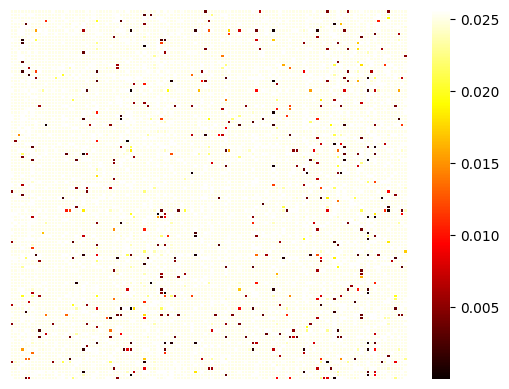

 28%|██████████████████████████████████████████████████████▋                                                                                                                                                | 11/40 [06:57<18:36, 38.52s/it]

Epoch: 11 | train_loss: 1.2705 | train_acc: 0.5568 | test_loss: 3.1947 | test_acc: 0.4659
CLFToken Gradeient Parameter containing:
tensor([[[-3.0167],
         [-0.6384],
         [ 1.4357],
         ...,
         [ 0.0107],
         [ 0.0520],
         [ 0.1069]]], device='cuda:0', requires_grad=True)


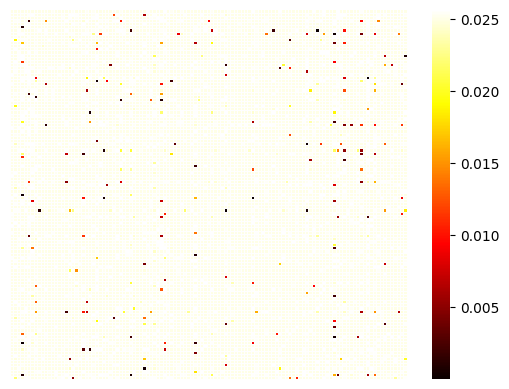

 30%|███████████████████████████████████████████████████████████▋                                                                                                                                           | 12/40 [07:35<17:50, 38.25s/it]

Epoch: 12 | train_loss: 1.1610 | train_acc: 0.5028 | test_loss: 1.3951 | test_acc: 0.4886
CLFToken Gradeient Parameter containing:
tensor([[[-5.0662],
         [-3.0725],
         [-1.3273],
         ...,
         [ 0.0090],
         [ 0.0436],
         [ 0.0897]]], device='cuda:0', requires_grad=True)


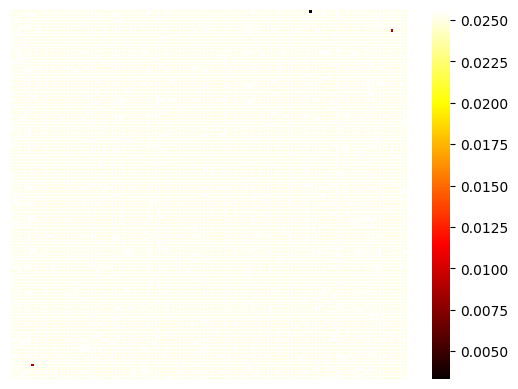

 32%|████████████████████████████████████████████████████████████████▋                                                                                                                                      | 13/40 [08:12<17:08, 38.11s/it]

Epoch: 13 | train_loss: 2.3547 | train_acc: 0.4432 | test_loss: 3.0417 | test_acc: 0.4659


In [ ]:
results = engine.train(Model , 
                TrainDataLoader,
                TestDataLoader,
                optimizer,
                loss_fn,
                Pivot,
                Part,
                save_weights,
                Epochs,
                device)

In [8]:
import numpy as np

In [9]:
sample = np.random.randn(Config.B , Config.T , Config.V , Config.V)
sample.shape

(1, 133, 117, 117)

In [11]:
sample = sample.mean(axis=1).mean(axis=0)

In [12]:
sample.shape

(117, 117)

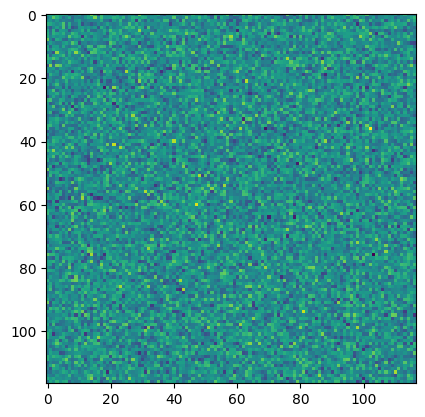

In [13]:
import matplotlib.pyplot as plt
plt.imshow(sample);

In [21]:
sample

torch.Size([1, 117, 117])

In [8]:
torch.ones(117).shape

torch.Size([117])

In [9]:
torch.diag(torch.ones(Config.V))

torch.Size([117, 117])